# Anomaly detection with an Autoencoder

An autoencoder is a type of artificial neural network used for unsupervised learning. It consists of an encoder and a decoder, both neural networks, and is designed to learn efficient representations of input data. The encoder compresses the input into a lower-dimensional representation (encoding), and the decoder reconstructs the input from this encoding. Autoencoders are widely used for tasks such as data compression, feature learning, and noise reduction, and they have applications in various fields, including image and speech recognition, anomaly detection, and generative modeling.

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, callbacks
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

from keras.datasets import mnist


The code defines a simple autoencoder using TensorFlow's Keras API. The autoencoder consists of an encoder and a decoder, each comprising fully connected layers. The model is designed for processing 28x28 dimensional data, such as images. 

In [2]:
class CustomCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            print("epoch {}, {}".format(epoch, logs))
   
class Autoencoder(tf.keras.models.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(8, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(784, activation='sigmoid'),
            tf.keras.layers.Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [26]:
def plot_digit_images(images, labels, digit, num_samples=5):
    # Select images and labels for the specified digit
    digit_indices = np.where(labels == digit)[0][:num_samples]
    digit_images = images[digit_indices]
    digit_labels = labels[digit_indices]
    
    # Create a figure with a grid layout
    plt.figure(figsize=(12, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(digit_images[i], cmap=plt.cm.gray_r)
        plt.title(f"Label: {digit_labels[i]}")
        plt.axis('off')

def plot_data_split(train, test):
    df_train = pd.DataFrame(train, columns=['target'])
    df_train['type'] = 'train'

    df_test = pd.DataFrame(test, columns=['target'])
    df_test['type'] = 'test'

    df_set = pd.concat([df_test, df_train])

    _ = sns.countplot(x='target', hue='type', data=df_set)

def compare_original_with_reconstructed(x_test, reconstructions):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
      # display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(x_test[i])
      plt.title("original")
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
    
      # display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(reconstructions[i])
      plt.title("reconstructed")
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
    plt.show()

def plot_loss(history):
    print(f"loss: {history.history['loss'][-1]}")
    print(f"val_loss: {history.history['val_loss'][-1]}")
    print(f"epoch: {len(history.history['loss'])}")

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

shape x-train: (60000, 28, 28)
shape y-train: (60000,)
shape x-test: (10000, 28, 28)
shape y-test: (10000,)
min value: 0
max value: 255


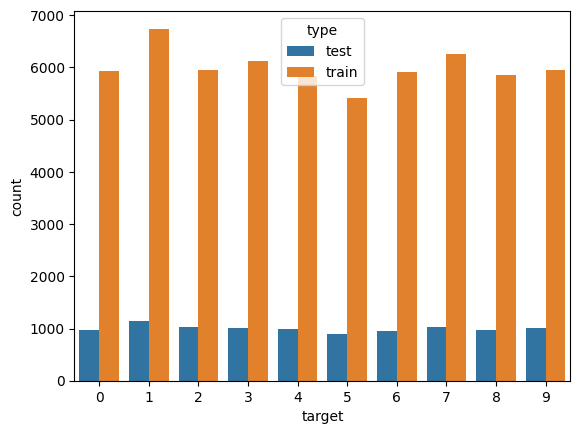

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("shape x-train: {}".format(np.shape(x_train)))
print("shape y-train: {}".format(np.shape(y_train)))
print("shape x-test: {}".format(np.shape(x_test)))
print("shape y-test: {}".format(np.shape(y_test)))

print("min value: {}".format(np.amin(x_train)))
print("max value: {}".format(np.amax(x_train)))

plot_data_split(y_train, y_test)

The code normalizes pixel values in x_train and x_test to the range [0, 1]. This normalization enhances neural network training stability, ensures consistent input representation, and is particularly beneficial for activation functions sensitive to input scale.

In [5]:
# Normalization
x_train = x_train.astype('float32') / np.amax(x_train)
x_test = x_test.astype('float32') / np.amax(x_test)

print("min value: {}".format(np.amin(x_train)))
print("max value: {}".format(np.amax(x_train)))

min value: 0.0
max value: 1.0


The code plots sample images from the training datafor digits 0 to 9.

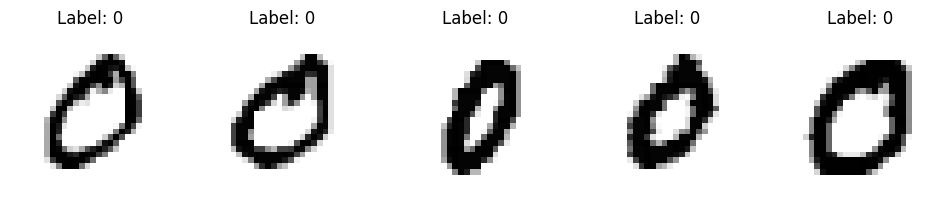

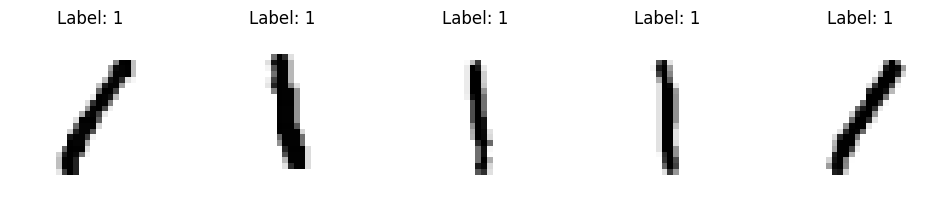

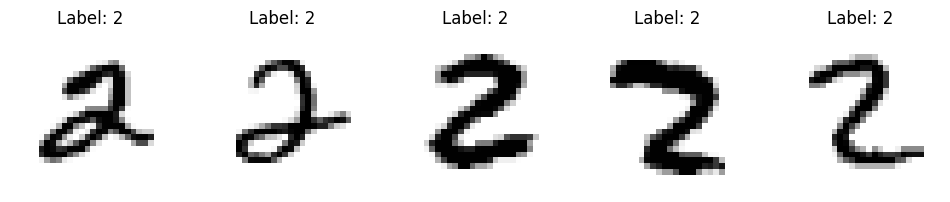

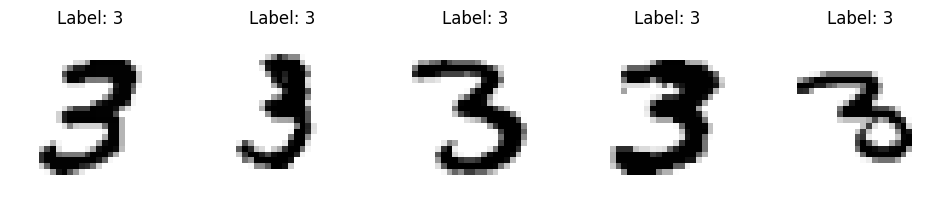

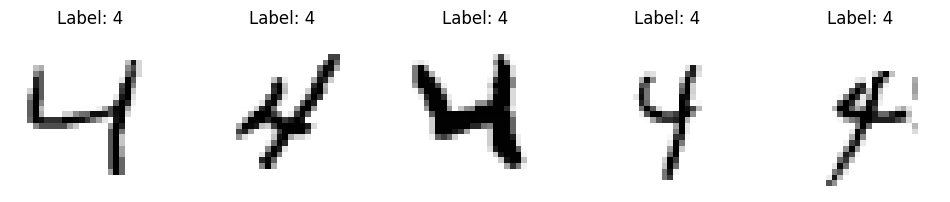

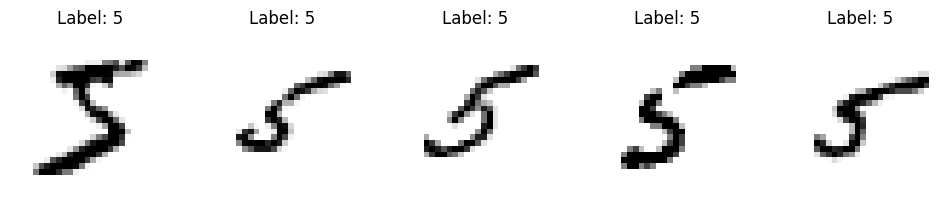

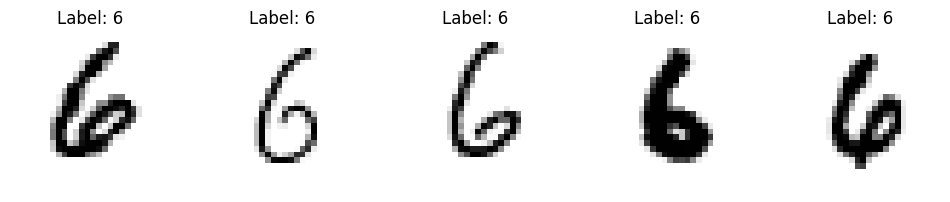

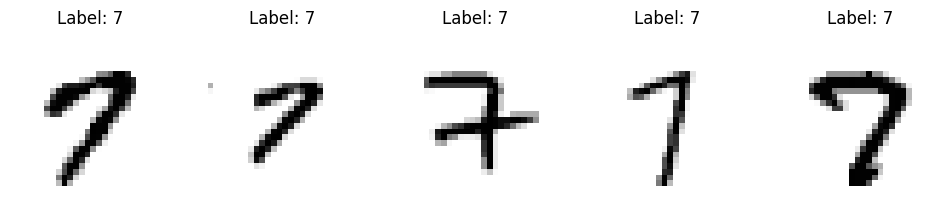

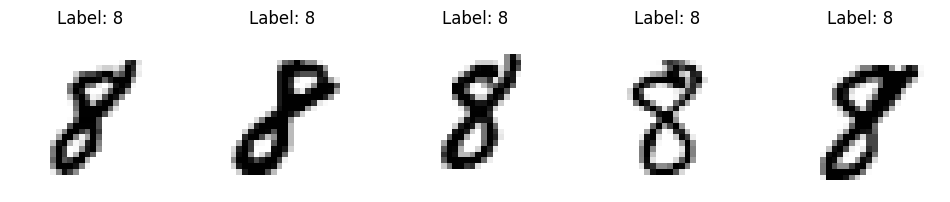

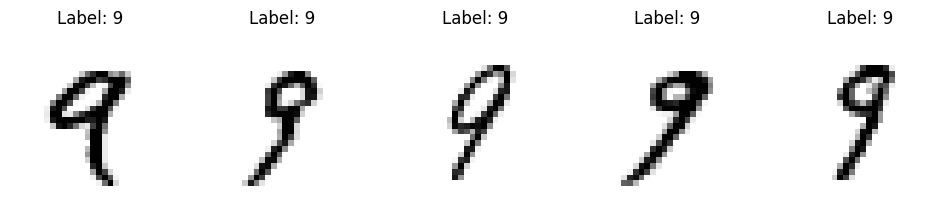

In [6]:
# inspect data
for digit in range(10):
    plot_digit_images(x_train, y_train, digit)

The code creates an autoencoder model with the Adam optimizer and binary crossentropy loss. It then trains the autoencoder on the x_train data for 200 epochs, using a batch size of 256 and a validation split of 20%. 

In [7]:
%%time
autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


history = autoencoder.fit(x_train, x_train,
                          epochs=200,
                          batch_size=256,
                          validation_split=0.2,
                          shuffle=True,
                          verbose=0,
                          callbacks=[CustomCallback()]
                          )


epoch 0, {'loss': 0.29333388805389404, 'val_loss': 0.23708593845367432}
epoch 10, {'loss': 0.16296295821666718, 'val_loss': 0.16288414597511292}
epoch 20, {'loss': 0.14911694824695587, 'val_loss': 0.14992594718933105}
epoch 30, {'loss': 0.14383628964424133, 'val_loss': 0.14568141102790833}
epoch 40, {'loss': 0.14115077257156372, 'val_loss': 0.14339029788970947}
epoch 50, {'loss': 0.13937470316886902, 'val_loss': 0.14233553409576416}
epoch 60, {'loss': 0.13803637027740479, 'val_loss': 0.14129383862018585}
epoch 70, {'loss': 0.1369531899690628, 'val_loss': 0.1405232548713684}
epoch 80, {'loss': 0.1360304206609726, 'val_loss': 0.13998930156230927}
epoch 90, {'loss': 0.13520845770835876, 'val_loss': 0.13927365839481354}
epoch 100, {'loss': 0.13463282585144043, 'val_loss': 0.13910678029060364}
epoch 110, {'loss': 0.13402001559734344, 'val_loss': 0.13899822533130646}
epoch 120, {'loss': 0.13358032703399658, 'val_loss': 0.1384698748588562}
epoch 130, {'loss': 0.13317041099071503, 'val_loss': 

In [8]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
195,0.131323,0.138301,195
196,0.131329,0.137848,196
197,0.131260,0.137775,197
198,0.131241,0.137886,198
199,0.131255,0.137610,199


loss: 0.13125520944595337
val_loss: 0.1376103311777115
epoch: 200


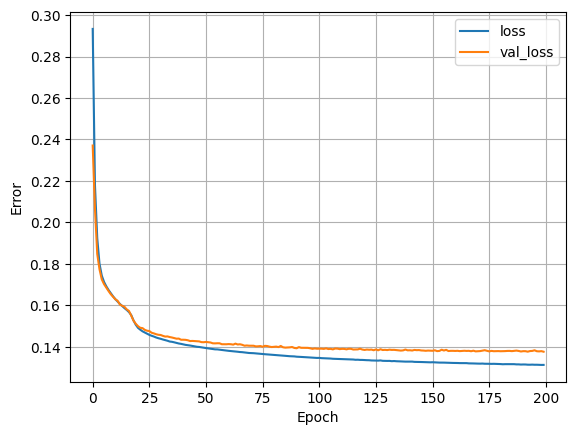

In [9]:
plot_loss(history)

This part uses the autoencoder model to generate reconstructions of test data for each digit from 0 to 9 and visualizes the reconstructions.

313/313 [==============================] - 0s 769us/step


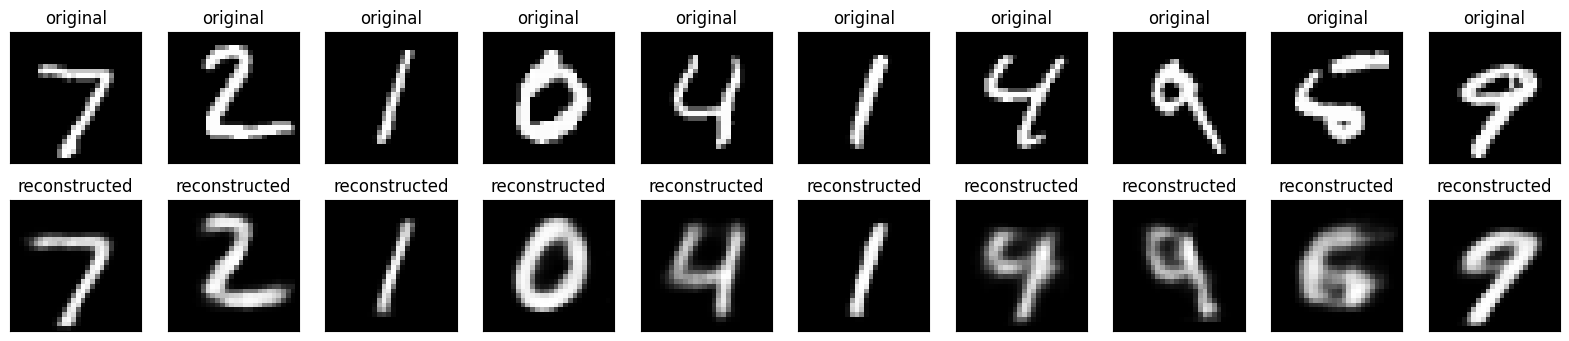

In [29]:
reconstructions = autoencoder.predict(x_test)

compare_original_with_reconstructed(x_test, reconstructions)

313/313 [==============================] - 0s 686us/step


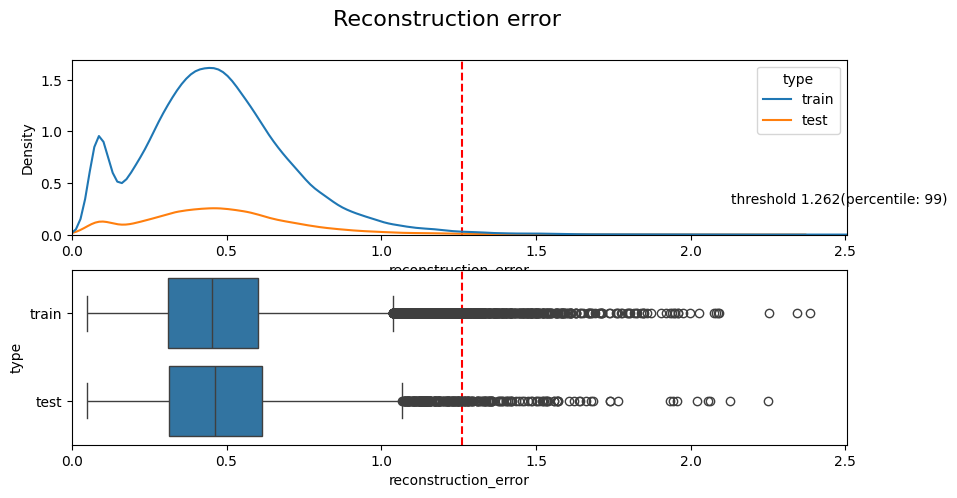

In [24]:
reconstruction_error_train = np.mean(tf.keras.losses.binary_crossentropy(autoencoder.predict(x_train), x_train), axis=1)
reconstruction_error_test = np.mean(tf.keras.losses.binary_crossentropy(autoencoder.predict(x_test), x_test), axis=1)



df_train = pd.DataFrame(reconstruction_error_train, columns=['reconstruction_error'])
df_train['type'] = 'train'

df_test = pd.DataFrame(reconstruction_error_test, columns=['reconstruction_error'])
df_test['type'] = 'test'

df_set = pd.concat([df_train, df_test])


fig, axs = plt.subplots(nrows=2, figsize=(10, 5))
fig.suptitle('Reconstruction error', fontsize=16)

p_threshold = 99
threshold = np.percentile(reconstruction_error_test, p_threshold)

x_max = np.max(reconstruction_error_test) + np.std(reconstruction_error_test)


axs[0].axvline(threshold, color='r', ls='--')
axs[0].set(xlim=(0, x_max))

axs[0].text(0.85, 0.2, 'threshold {:.3f}(percentile: {})'.format(threshold, p_threshold), horizontalalignment='left', verticalalignment='center', transform=axs[0].transAxes)


axs[1].axvline(threshold, color='r', ls='--')
axs[1].set(xlim=(0, x_max))


_ = sns.kdeplot(data=df_set, x='reconstruction_error' ,hue='type', ax=axs[0])
_ = sns.boxplot(data=df_set, x='reconstruction_error', y='type', orient='h', ax=axs[1])

Reconstruction error is a measure of the dissimilarity between the input data and the output generated by a model. In autoencoders, the goal is to learn a compressed representation of the input and then reconstruct it. A lower reconstruction error indicates better performance, as the model effectively captures essential features for accurate reconstruction. This concept is vital in tasks like data compression, denoising, and feature learning.


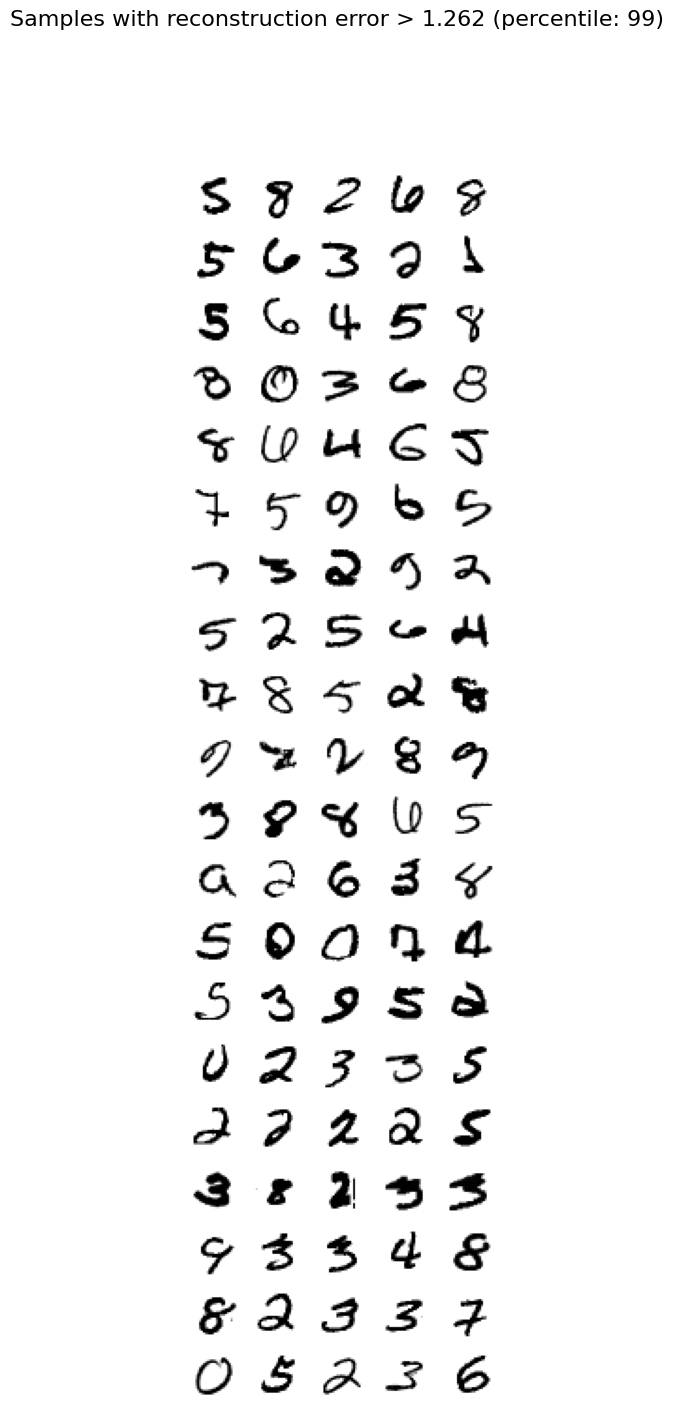

In [16]:
anomalies_index = np.argwhere(reconstruction_error_test > threshold).flatten()

anomalies_x = np.array(x_test)[anomalies_index] 
anomalies_y = np.array(y_test)[anomalies_index] 


num_rows = int(np.ceil(len(anomalies_x) / 5))

# Create a figure with subplots for 5 images per row
fig, axes = plt.subplots(num_rows, 5, figsize=(4, 16))
fig.suptitle('Samples with reconstruction error > {:.3f} (percentile: {})'.format(threshold, p_threshold), fontsize=16)

# Flatten the 2D array of subplots for easier indexing
axes = axes.flatten()

for ax, image, label in zip(axes, anomalies_x, anomalies_y):
    if ax is not None:
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r)
        #ax.set_title('%i' % label)

plt.show()

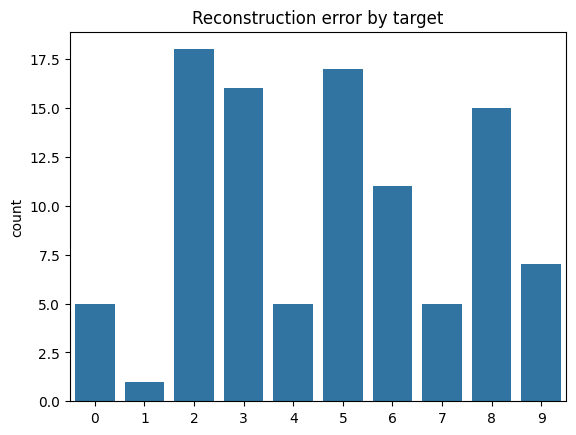

In [17]:
_ = sns.countplot(x=anomalies_y).set_title('Reconstruction error by target') 